In [1]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import math
from sklearn.tree import DecisionTreeRegressor

### Criando as funções

In [2]:
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [3]:
def apl_model (df_st,n_lags):

    print('Janela Analizada: ', n_lags,'dias\n')

    X = get_lags(df_st, n_lags)
    y = df_st.reindex(X.index)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.3)

    parameters = {'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
             'splitter': ['best', 'random'],
             'max_depth': range(20)
             }

    dtr = DecisionTreeRegressor()
    dtr_GS = GridSearchCV (dtr, parameters, cv = TimeSeriesSplit(), error_score='raise')
    res = dtr_GS.fit(X_train,y_train)

    print('#'*40)
    print('Melhor Score: ', res.best_score_)
    print('Melhores Parametros: ', res.best_params_)
    print('#'*40)

    print('Aplicando o Medelo Para os Melhores Parametros: \n\n\n')

    parameters = {'criterion': [res.best_params_['criterion']],
             'splitter': [res.best_params_['splitter']],
             'max_depth': [res.best_params_['max_depth']]}
    
    dtr = DecisionTreeRegressor()
    dtr_GS = GridSearchCV (dtr, parameters, cv = TimeSeriesSplit(), error_score='raise')
    res = dtr_GS.fit(X_train,y_train)
    print( res.best_score_, res.best_params_)

    r2 = r2_score(dtr_GS.predict(X_test),y_test)
    mse = mean_squared_error(dtr_GS.predict(X_test),y_test)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(dtr_GS.predict(X_test),y_test)
    mape = mean_absolute_percentage_error(dtr_GS.predict(X_test),y_test)

    print('SVR model Results')
    print('r2' ,r2)
    print('mse' , mse)
    print('rmse', rmse)
    print('mae', mae)
    print('mape',  mape)

    fig, ax = plt.subplots()
    ax.plot(dtr_GS.predict(X_test).flatten(), label='pred')
    ax.plot(y_test.reset_index(drop=True), label='true')
    plt.title('KNN MODEL')
    plt.legend()
    plt.show()

    print('Plot dos Resíduos: ')
    res = dtr_GS.predict(X_test).flatten() - y_test.reset_index(drop=True).values.flatten()
    pd.Series(res).plot()
    print('Distribuição dos residuos: ')
    pd.Series(res).plot.kde()
    
    return r2, mse, rmse, mae, mape

In [4]:
def apl_for_lags (df_st):
    janelas = [ 7, 15, 30, 45, 60]
    results = []

    for janela in janelas:
        r2, mse, rmse, mae, mape = apl_model (df_st, janela)
        result = [r2, mse, rmse, mae, mape]
        results.append(result)

    return results

### Lendo dataset

In [5]:
df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')

df_st = df['data_notificacao'].value_counts().rename_axis('Data_notificacao').to_frame('N_casos')
df_st.sort_index(inplace = True)
df_st

C:\Users\gabri\AppData\Local\Temp\ipykernel_15812\2810962173.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')


,N_casos
Data_notificacao,
2020-01-12,1
2020-01-20,3
2020-01-22,1
2020-01-24,1
2020-01-25,1
...,...
2022-06-17,1327
2022-06-18,550
2022-06-19,552


### Aplicando o Modelo

Janela Analizada:  7 dias

########################################
Melhor Score:  0.2984616138632947
Melhores Parametros:  {'criterion': 'absolute_error', 'max_depth': 5, 'splitter': 'random'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.23216110673842474 {'criterion': 'absolute_error', 'max_depth': 5, 'splitter': 'random'}
SVR model Results
r2 -4.679603505403061
mse 1850631.4622448978
rmse 1360.379161206499
mae 647.4714285714285
mape 0.6382790438955249


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages

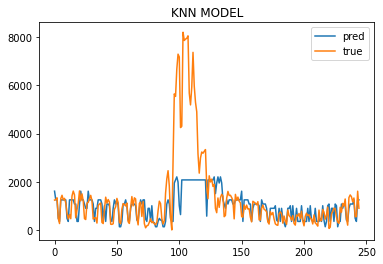

Plot dos Resíduos: 
Distribuição dos residuos: 
Janela Analizada:  15 dias

########################################
Melhor Score:  0.27705693089931743
Melhores Parametros:  {'criterion': 'poisson', 'max_depth': 3, 'splitter': 'random'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.21841666824508182 {'criterion': 'poisson', 'max_depth': 3, 'splitter': 'random'}
SVR model Results
r2 -6.14244981260591
mse 1970345.7547052726
rmse 1403.6900493717524
mae 696.4887201013794
mape 0.7412732844037645


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages

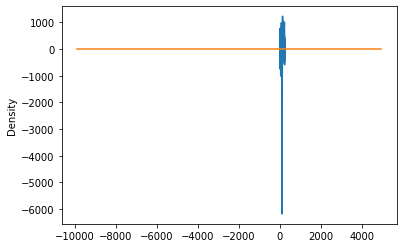

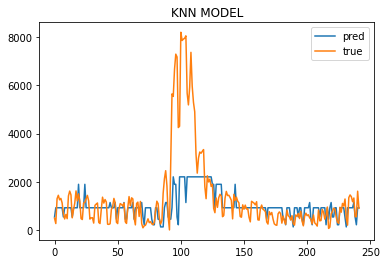

Plot dos Resíduos: 
Distribuição dos residuos: 
Janela Analizada:  30 dias

########################################
Melhor Score:  0.284184892861947
Melhores Parametros:  {'criterion': 'poisson', 'max_depth': 3, 'splitter': 'random'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.1837836306621558 {'criterion': 'poisson', 'max_depth': 3, 'splitter': 'random'}
SVR model Results
r2 -7.36210028518402
mse 2461729.363461381
rmse 1568.9899182153406
mae 733.8034960877736
mape 0.7572868855116688


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages

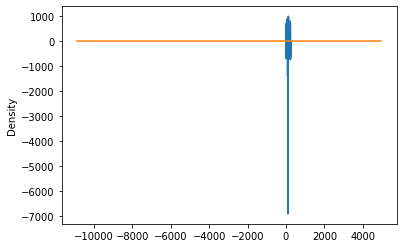

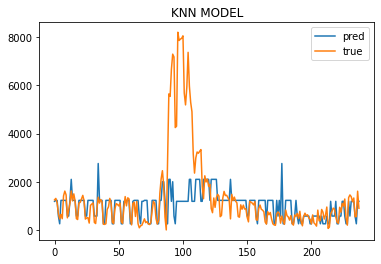

Plot dos Resíduos: 
Distribuição dos residuos: 
Janela Analizada:  45 dias



C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages

########################################
Melhor Score:  0.3324709455897474
Melhores Parametros:  {'criterion': 'friedman_mse', 'max_depth': 4, 'splitter': 'best'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.26584717639333383 {'criterion': 'friedman_mse', 'max_depth': 4, 'splitter': 'best'}
SVR model Results
r2 -4.380253489411219
mse 1944830.360037156
rmse 1394.5717478986714
mae 668.5632744851595
mape 0.7485562942634824


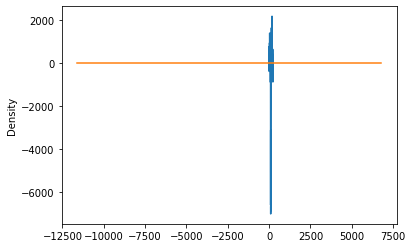

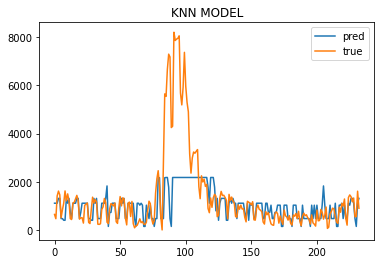

Plot dos Resíduos: 
Distribuição dos residuos: 
Janela Analizada:  60 dias

########################################
Melhor Score:  0.36509655399614227
Melhores Parametros:  {'criterion': 'poisson', 'max_depth': 2, 'splitter': 'best'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.36509655399614227 {'criterion': 'poisson', 'max_depth': 2, 'splitter': 'best'}
SVR model Results
r2 -5.553493643488606
mse 2086369.819386276
rmse 1444.427159598668
mae 685.2118595408111
mape 0.806783309172292


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages

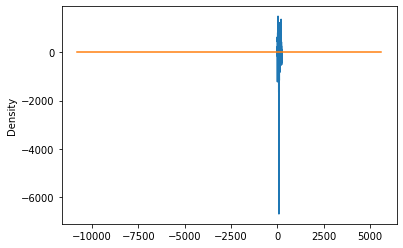

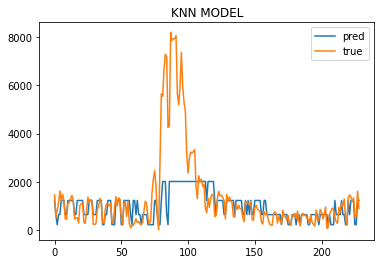

Plot dos Resíduos: 
Distribuição dos residuos: 


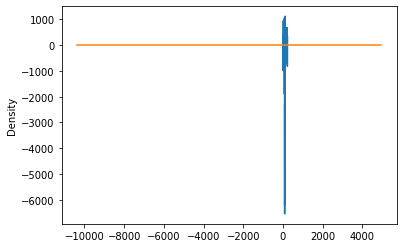

In [6]:
results = apl_for_lags (df_st)

### Resultados

In [9]:
df_results = pd.DataFrame(results, columns=('R2', 'MSE', 'RMSE','MAE','MAPE' ), index=('7 dias', '15 dias', '30 dias', '45 dias', '60 dias'))
df_results

,R2,MSE,RMSE,MAE,MAPE
7 dias,-4.679604,1.850631e+06,1360.379161,647.471429,0.638279
15 dias,-6.142450,1.970346e+06,1403.690049,696.488720,0.741273
30 dias,-7.362100,2.461729e+06,1568.989918,733.803496,0.757287
45 dias,-4.380253,1.944830e+06,1394.571748,668.563274,0.748556
60 dias,-5.553494,2.086370e+06,1444.427160,685.211860,0.806783
